# <span style="color:#336699">CAP-394 - Introdução à Data Science</span>
<hr style="border:2px solid #336699;">

- Gilberto Ribeiro de Queiroz
- Rafael Duarte Coelho dos Santos

# <span style="color:#336699">Satellite Image Time Series (SITS) R package</span>

[<img src="https://avatars1.githubusercontent.com/u/12664233?s=200&v=4" alt="GeoPandas" width="100" align="right">](https://github.com/e-sensing/wtss.py)


Colaboradores:
- Rolf Simões

## <span style="color:#336699">Overview</span>
<hr style="border:1px solid #336699;">

<center>
<img src="./img/overview.png" alt="SITS package process overview" style="width: 800px;"/>
</center>

## <span style="color:#336699">SITS - Satellite Image Time Series</span>
<hr style="border:1px solid #336699;">

The **__S__**atellite **__I__**mage **__T__**ime **__S__**eries (SITS) is a open source R package for handling, analysis and classification of time series data from remote sensing imagery.

In what follows, we show how to use the basics SITS functionalities: how to retrieve data, do clustering analysis, and proceed land cover classifications. 

### <span style="color:#336699">Load data into SITS from WTSS</span>
<hr style="border:0.5px solid #336699;">

SITS uses coverages to load data samples or raster bricks to be classified. To specify some data source, SITS provides some predefined services that can be used to retrieve data. These services can be "WTSS-INPE", "SATVEG", and "RASTER". The WTSS is a time series service provided by INPE. The SATVEG is a time series service provided by Embrapa (https://www.satveg.cnptia.embrapa.br/satveg/login.html). RASTER is the service used to access any local raster files compatible with GDAL.

1) Load `sits` library:

In [ ]:
library(sits)

2) In `sits` we access data through coverage services. In next line shows available data sources services:

In [ ]:
sits_services()

3) We access data by creating a coverage. In next line we connect to WTSS on INPE:

In [ ]:
coverage <- sits_coverage(service = "WTSS-INPE", name = "MOD13Q1")

In [ ]:
print(coverage)

4) To retrieve a time series from a location, we need provide the longitude and latitude, the time range (start and end dates), and the bands:

In [5]:
longitude <- -55.5027
latitude  <- -11.7181

start <- "2010-09-01"
end   <- "2011-08-31"

bands <-  c("ndvi", "evi", "nir", "mir")

point <- sits_getdata(coverage = coverage,
                      longitude = longitude,
                      latitude = latitude,
                      start_date = start,
                      end_date = end,
                      bands = bands)

5) Plot all bands' time series

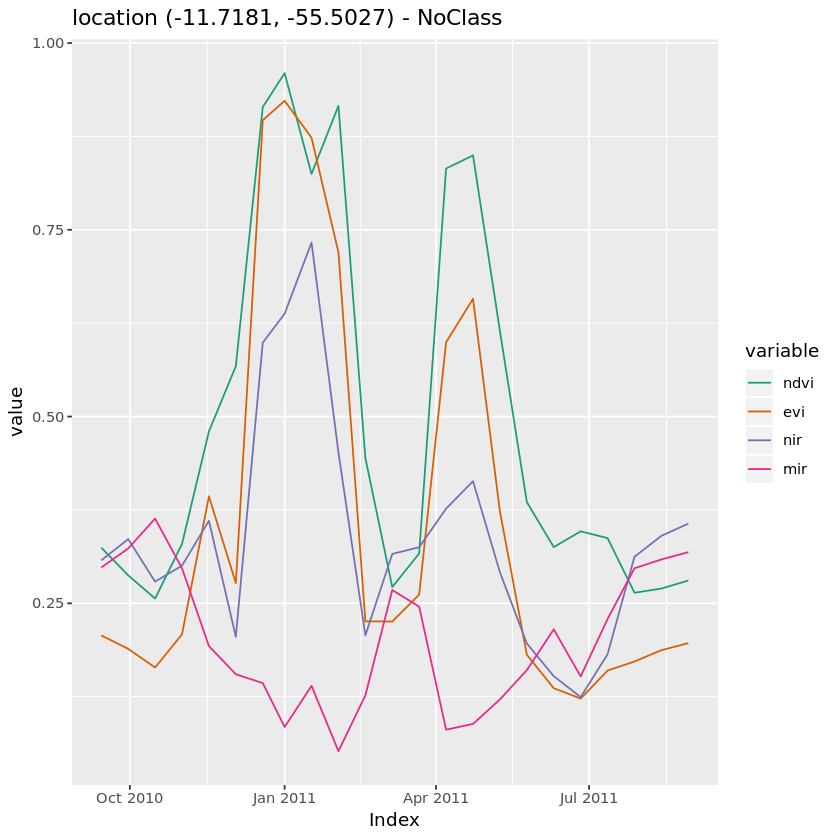

In [6]:
sits_plot(point)

5) Load WTSS data using a CSV file:

In [ ]:
samples <- sits_getdata(file = "/tmp/samples.csv", 
                        bands = bands, coverage = coverage)

In [ ]:
print(samples)

In [ ]:
print(samples$time_series[[1]])

### <span style="color:#336699">Load data into SITS from a raster file</span>
<hr style="border:0.5px solid #336699;">


1) Provide a TIF file and the band name:

In [ ]:
file <- 
  system.file("extdata/raster/mod13q1/sinop-crop-ndvi.tif", 
              package = "sits")

band <- c("ndvi")

coverage <- sits_coverage(service = "RASTER", 
                          name = "Any name", 
                          timeline = timeline_modis_392, 
                          bands = band, files = file)



2) Provide a coordinate location. If no time range is informed, all time series are retrieved:

In [ ]:
longitude <- -55.56
latitude  <- -11.53

point <- sits_getdata(coverage = coverage,
                      longitude = longitude,
                      latitude = latitude)

sits_plot(point)

## Cluster Analysis
<hr style="border:2px solid #0077b9;">

SITS provides aglomerative hierarchical clustering. The procedure consists in compute a dendrogram that must be cutted at some level to produce clusters. The main functions for clustering are:

- `sits_dendrogram` - compute a dendrogram tree given a distance function and a linkage criterion;<br><br>

- `sits_cluster` - cuts the tree to produce clusters;<br><br>

- `sits_plot_dendrogram` - plot the dendrogram graphics.<br><br>


1) Load SITS package's samples NDVI time series `samples_MT_ndvi`:

In [ ]:
samples <- samples_MT_ndvi

2) How many classes are therein?

In [ ]:
print(sits_labels(samples))

3) To proceed with cluster analysis, you must load `proxy` library. This package provides support to disances/dimilarities functions used by hierarchical clustering:

In [ ]:
source('/tmp/sits_patch.R')

In [ ]:
library(proxy)
library(dtwclust)

dendrogram <- sits_dendrogram2(samples, 
                               dist_method = "Cosine", 
                               linkage = "ward.D2")

2) Plot the dendrogram tree:

In [ ]:
sits_plot_dendrogram(samples, dendrogram)

3) Find the number of clusters that minimizes the Adjusted Rand Index: 

In [ ]:
print(sits_dendro_bestcut(samples, dendrogram))

4) Cut the dendrogram and generates the clusters: 

In [ ]:
clusters <- sits_cluster(samples, dendrogram, k = 12)

5) The returned SITS table has a `cluster` column that indicates the cluster number of each sample:

In [ ]:
print(clusters)

6) Print the cluster vs. samples frequency:

In [ ]:
print(sits_cluster_frequency(clusters))

## Machine Learning
<hr style="border:2px solid #0077b9;">

SITS provides a set of machine learning classification methods. The procedure consists in training a model, and classifying some data (isolated time series, or raster TIF). Furthermore, SITS can compute accuracy estimation by cross validation (k-fold validation) procedure. The main functions for machine learning are:

- `sits_train` - compute the machine learning model to be used in classification task;<br><br>

- `sits_classify`, `sits_classify_raster` - process the classification task. The first function operates over a SITS table. The second function operates over a "RASTER" coverage;<br><br>

- `sits_kfold_validate` - estimates the accuracy error for a given machine leatning method.<br><br>


### <span style="color:#336699">Support Vector Machine</span>
<hr style="border:0.5px solid #336699;">


1) Train SVM model using `sits_svm` function:

In [ ]:
svm_model <- sits_train(samples, ml_method = sits_svm())

2) Classify an isolated time series data using the SVM trained model:

In [ ]:
classification <- sits_classify(point, ml_model = svm_model)

3) Plot classification result:

In [ ]:
sits_plot(classification)

4) The last year was not classified due to some `NA` data in time series. We can interpolate all `NA` values by calling `sits_linear_interp` function that returns a new time series with a given number of interpolated values: 

In [ ]:
point  <- sits_linear_interp(point, n = 392)

classification <- sits_classify(point, ml_model = svm_model)
sits_plot(classification)

5) How does `sits_svm` function work?

In [ ]:
?sits_svm

### <span style="color:#336699">Random Forest</span>
<hr style="border:0.5px solid #336699;">


1) Train a random forest model using `sits_rfor` function: 

In [ ]:
rfor_model <- sits_train(samples, ml_method = sits_rfor(num.trees = 500))

2) How does `sits_rfor` work?

In [ ]:
?sits_rfor

3) Classify an isolated time series using the trained random forest model:

In [ ]:
classification <- sits_classify(point, ml_model = rfor_model)

4) Plot the classification result:

In [ ]:
sits_plot(classification)

### <span style="color:#336699">Deep Learning</span>
<hr style="border:0.5px solid #336699;">


1) Train a model using `sits_deeplearning` function as parameter:

In [ ]:
library(keras)
dl_model <- sits_train(samples, 
                       ml_method = sits_deeplearning(units = c(512, 512, 512),
                                                     dropout_rates = c(0.50, 0.40, 0.35),
                                                     epochs = 50))

2) How does `sits_deeplearning` function works?

In [ ]:
?sits_deeplearning

3) Classify an isolated time series using the deep learning model: 

In [ ]:
classification <- sits_classify(point, ml_model = dl_model)

4) Plot the classification result:

In [ ]:
sits_plot(classification)

### <span style="color:#336699">Raster Classification</span>
<hr style="border:0.5px solid #336699;">


1) To classify a raster TIF, we need a "RASTER" coverage and a machine learning model:

In [ ]:
raster_class <- sits_classify_raster(file = "./classificacao", 
                                     coverage = coverage, 
                                     ml_model = svm_model, multicores = 1)

2) Plot the raster classification result for the year 2015:

In [ ]:
sits_plot_raster(raster_class, time = 16)

3) Plot the probabilities associated with model classification:

In [ ]:
names(raster_class$r_objs[[2]][[16]]) <- sits_labels(samples)$label
plot(raster_class$r_objs[[2]][[16]])

### <span style="color:#336699">Accuracy Estimation</span>
<hr style="border:0.5px solid #336699;">


1) Call `sits_kfold_validate` function to run a k-fold cross validation:

In [ ]:
kfold <- sits_kfold_validate(samples, folds = 5, 
                             ml_method = sits_svm(), multicores = 4)

2) Print the accuracies estimatives:

In [ ]:
sits_conf_matrix(kfold)

## <span style="color:#336699">References</span>
<hr style="border:0.5px solid #336699;">

* [SITS](https://github.com/e-sensing/sits)<br><br>

* [R Client API for Web Time Series Service](https://github.com/e-sensing/wtss)